In [1]:
# load spikes

# for each session

# subset spikes occuring in specific states

# calculate rate changes, cv-isi changes, change in burst frequency, population coupling changes, pairwise cross corr, pairwise pcorr

# compare across clusters

# compare only good eeg extractions


In [1]:
from drn_interactions.spikes import SpikesHandler
from drn_interactions.load import load_derived_generic, load_neurons, load_recordings
from binit.bin import which_bin, which_bin_idx
from sklearn.covariance import GraphicalLassoCV

import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np

from scipy.stats import zscore

from tqdm.notebook import tqdm
from spiketimes.statistics import mean_firing_rate
from drn_interactions.stats import cv_isi_burst, is_burster
from drn_interactions.spikes import get_population_train, pop_population_train

from sklearn.covariance import GraphicalLasso


from drn_interactions.cross_correlations import ccf
from drn_interactions.stats import auc

In [2]:
def get_state_piv(spikes, eeg, state_col="state", index_name="bin", eeg_time_col="timepoint_s"):
    spikes = spikes.copy()
    return (
        spikes
        .reset_index()
        .assign(eeg_time = lambda x: which_bin(x[index_name].values, eeg[eeg_time_col].values, time_before=0, time_after=2))
        .merge(eeg, left_on="eeg_time", right_on=eeg_time_col)
        .set_index(index_name)
        [list(spikes.columns) + [state_col]]
    )

def get_state_long(spikes, eeg, index_name="bin", eeg_time_col="timepoint_s"):
    return (
        spikes
        .reset_index()
        .copy()
        .assign(eeg_bin = lambda x: which_bin(x[index_name].values, eeg[eeg_time_col].values, time_before=0, time_after=2))
        .merge(eeg, left_on="eeg_bin", right_on="timepoint_s")
        .drop("timepoint_s", axis=1)
    )


def zero_diag(df):
    values = df.values
    np.fill_diagonal(values, 0)
    return pd.DataFrame(values, index=df.index, columns=df.columns)

def filter_active(df, thresh=0):
    sums = df.sum()
    to_exclude = sums[sums <= thresh].index.values
    return df[[c for c in df.columns if c not in to_exclude]]


class PopulationCoupling:

    def __init__(self, nlags, method="ccf"):
        self.nlags = nlags
        self.method = method
    
    def get_couplings(self, df_piv):
        time_interval = np.diff(df_piv.index.values)[0]
        frames = []
        df_piv = filter_active(df_piv)
        for neuron_id in df_piv.columns:
            neuron, pop_train = pop_population_train(df_piv, neuron_id)
            if neuron[neuron_id].sum() == 0:
                continue
            lags, vals =  ccf(neuron[neuron_id], pop_train["population"], adjusted=False)
            time = lags * time_interval
            zero_index = int(np.argwhere(time == 0))
            start_idx = zero_index - self.nlags
            stop_idx = zero_index +  self.nlags
            frames.append(pd.DataFrame({"neuron_id": neuron_id, "lag": lags, "time": time, "cc": vals}).iloc[start_idx:stop_idx])
        return pd.concat(frames)
    
def popcup(df, nlags=100, name="popcup"):
    out = PopulationCoupling(nlags=nlags).get_couplings(df)
    return out.groupby("neuron_id")["cc"].apply(lambda x: auc(x.abs())).to_frame(name).reset_index()


def popcup_zerolag(df, nlags=100, name="popcup"):
    out = PopulationCoupling(nlags=nlags).get_couplings(df)
    return out.loc[lambda x: x.lag == 0].rename(columns={"cc": name})[["neuron_id", name]]


def _avg_pairwise_pcorr(df):
    return df.apply(zscore).dropna(axis=1).pcorr().mean()


def avg_pairwise_pcorr_by(df, state_col="state", name="avg_pcorr"):
    res = df.groupby(state_col).apply(_avg_pairwise_pcorr).reset_index()
    if "level_1" in res.columns:
        res = res.drop("level_1", axis=1)
    return res.melt(id_vars=state_col, var_name="neuron_id", value_name=name)


def _avg_pairwise_corr(df):
    return df.apply(zscore).dropna(axis=1).corr().mean()


def avg_pairwise_corr_by(df, state_col="state", name="avg_corr"):
    res = df.groupby(state_col).apply(_avg_pairwise_corr).reset_index()
    if "level_1" in res.columns:
        res = res.drop("level_1", axis=1)
    return res.melt(id_vars=state_col, var_name="neuron_id", value_name=name)



In [3]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})

eeg_states =eeg_states.loc[lambda x: x.quality == "good"]

neurons = load_neurons()

sessions = neurons[["session_name"]].drop_duplicates().merge(eeg_states[["session_name"]].drop_duplicates())["session_name"].unique()
t_start=0
t_stop=1800
bin_width=0.1

In [4]:
session_name = sessions[1]
eeg = eeg_states.loc[lambda x: x.session_name == session_name]
sh = SpikesHandler(block="pre", t_start=0, t_stop=1800, bin_width=0.1, session_names=[session_name])

bins_state = get_state_piv(sh.binned_piv, eeg)
act_spikes = bins_state.loc[lambda x: x.state == "act"].drop("state", axis=1)
sw_spikes = bins_state.loc[lambda x: x.state == "sw"].drop("state", axis=1)

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
df_list = []
for session_name in tqdm(sessions):
    eeg = eeg_states.loc[lambda x: x.session_name == session_name]
    sh_long = SpikesHandler(block="pre", t_start=0, t_stop=1800, bin_width=1, session_names=[session_name])
    df = get_state_long(sh_long.spikes, eeg[["timepoint_s", "state"]], index_name="spiketimes")
    mfr = df.groupby(["neuron_id", "state",])["spiketimes"].apply(mean_firing_rate).to_frame(name="mfr").reset_index()
    cv_b = df.groupby(["neuron_id", "state"])["spiketimes"].apply(cv_isi_burst).to_frame(name="cv_burst").reset_index()
    
    bins_state_long = get_state_piv(filter_active(sh_long.binned_piv), eeg)

    popc_long = bins_state_long.groupby("state").apply(popcup_zerolag, nlags=100, name="pc_long").reset_index().drop("level_1", axis=1)
    pcorr_long = avg_pairwise_pcorr_by(bins_state_long, state_col="state", name="pcorr_long")
    corr_long = avg_pairwise_corr_by(bins_state_long, state_col="state", name="corr_long")


    sh_short = SpikesHandler(block="pre", t_start=0, t_stop=1800, bin_width=0.01, session_names=[session_name])
    bins_state_short = get_state_piv(filter_active(sh_short.binned_piv), eeg)
    pcorr_short = avg_pairwise_pcorr_by(bins_state_short, state_col="state", name="pcorr_short")
    corr_short = avg_pairwise_corr_by(bins_state_short, state_col="state", name="corr_short")

    popc_short = bins_state_short.groupby("state").apply(popcup_zerolag, nlags=100, name="pc_short").reset_index().drop("level_1", axis=1)
    
    res = mfr.merge(cv_b).merge(popc_long).merge(popc_short).merge(pcorr_long, how="outer").merge(pcorr_short,how="outer").merge(corr_long).merge(corr_short).assign(session_name=session_name)
    df_list.append(res)

  0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\pingouin\correlation.py:929: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / np.diag(Vi)))
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in tr

In [6]:
# from drn_interactions.load import load_clusters

# clusters = load_derived_generic("clusters.csv")
clusters = load_derived_generic("graph_clusters.csv")

df_res = pd.concat(df_list).merge(clusters)

In [7]:
df_res.columns

Index(['neuron_id', 'state', 'mfr', 'cv_burst', 'pc_long', 'pc_short',
       'pcorr_long', 'pcorr_short', 'corr_long', 'corr_short', 'session_name',
       'hdb', 'louvain'],
      dtype='object')

In [8]:
clusters.columns

Index(['neuron_id', 'hdb', 'louvain'], dtype='object')

In [9]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [19]:
mod = smf.ols("mfr ~ state * hdb", data=df_res).fit()

anova_lm(mod).round(2)

,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,7.92,7.92,0.64,0.43
hdb,1.0,81.24,81.24,6.56,0.01
state:hdb,1.0,0.07,0.07,0.01,0.94
Residual,78.0,966.20,12.39,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,7.92,7.92,0.64,0.43
hdb,1.0,81.24,81.24,6.56,0.01
state:hdb,1.0,0.07,0.07,0.01,0.94
Residual,78.0,966.20,12.39,NaN,NaN


<Figure size 432x288 with 0 Axes>

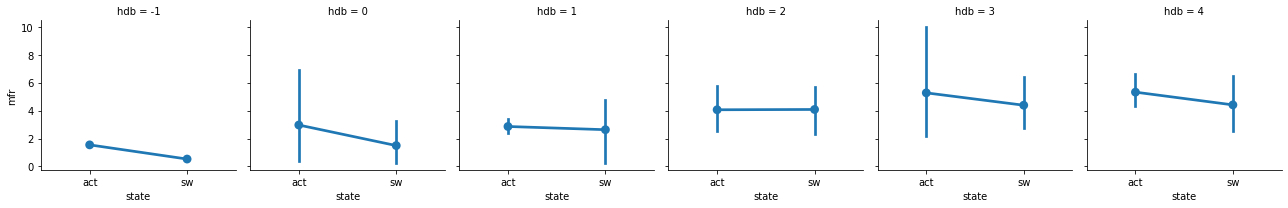

In [20]:
plt.figure()
sns.FacetGrid(data=df_res, col="hdb", sharey=True).map_dataframe(sns.pointplot, x="state", y="mfr")
mod = smf.ols("mfr ~ state * hdb", data=df_res).fit()
anova_lm(mod).round(2)

,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,0.08,0.08,2.43,0.12
hdb,1.0,0.36,0.36,10.64,0.00
state:hdb,1.0,0.01,0.01,0.24,0.62
Residual,78.0,2.63,0.03,NaN,NaN


<Figure size 432x288 with 0 Axes>

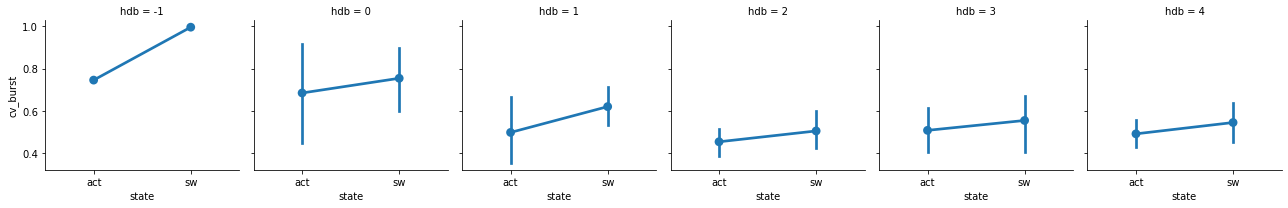

In [21]:
plt.figure()
sns.FacetGrid(data=df_res, col="hdb", sharey=True).map_dataframe(sns.pointplot, x="state", y="cv_burst")

mod = smf.ols("cv_burst ~ state * hdb", data=df_res).fit()
anova_lm(mod).round(2)

,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,0.01,0.01,16.35,0.00
hdb,1.0,0.00,0.00,0.22,0.64
state:hdb,1.0,0.00,0.00,0.16,0.69
Residual,78.0,0.03,0.00,NaN,NaN


<Figure size 432x288 with 0 Axes>

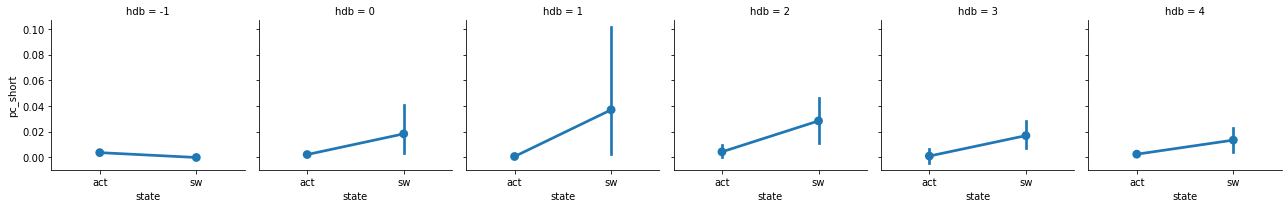

In [22]:
plt.figure()
sns.FacetGrid(data=df_res, 
col="hdb", sharey=True).map_dataframe(sns.pointplot, x="state", y="pc_short")

mod = smf.ols("pc_short ~ state * hdb", data=df_res).fit()
anova_lm(mod).round(2)

,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,0.06,0.06,2.26,0.14
hdb,1.0,0.01,0.01,0.53,0.47
state:hdb,1.0,0.01,0.01,0.35,0.56
Residual,78.0,2.05,0.03,NaN,NaN


<Figure size 432x288 with 0 Axes>

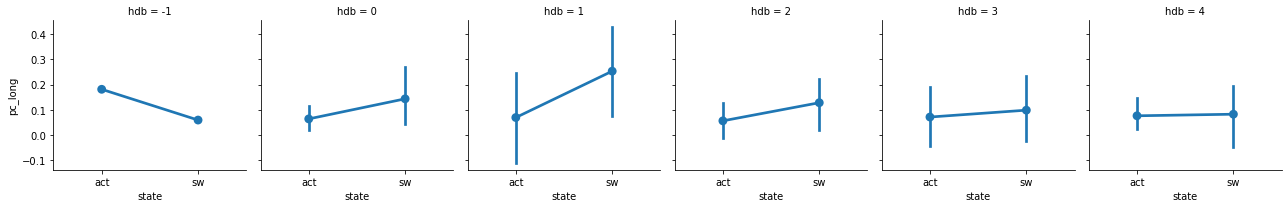

In [26]:
plt.figure()
sns.FacetGrid(data=df_res, 
col="hdb", sharey=True).map_dataframe(sns.pointplot, x="state", y="pc_long")

mod = smf.ols("pc_long ~ state * hdb", data=df_res).fit()
anova_lm(mod).round(2)


,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,0.00,0.00,0.48,0.49
hdb,1.0,0.01,0.01,6.72,0.01
state:hdb,1.0,0.00,0.00,0.00,0.95
Residual,78.0,0.09,0.00,NaN,NaN


<Figure size 432x288 with 0 Axes>

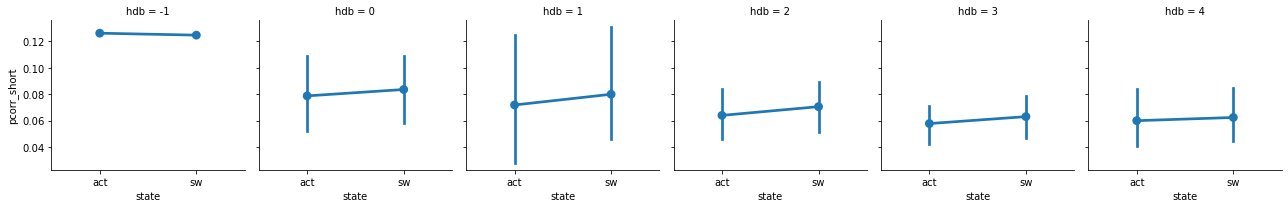

In [27]:
df_res["pcorr_short_abs"] = df_res["pcorr_short"].abs()

plt.figure()
sns.FacetGrid(data=df_res, col="hdb", sharey=True).map_dataframe(sns.pointplot, x="state", y="pcorr_short")

mod = smf.ols("pcorr_short ~ state * hdb", data=df_res).fit()
anova_lm(mod).round(2)

,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,0.00,0.00,0.34,0.56
hdb,1.0,0.02,0.02,6.88,0.01
state:hdb,1.0,0.00,0.00,0.01,0.92
Residual,78.0,0.23,0.00,NaN,NaN


<Figure size 432x288 with 0 Axes>

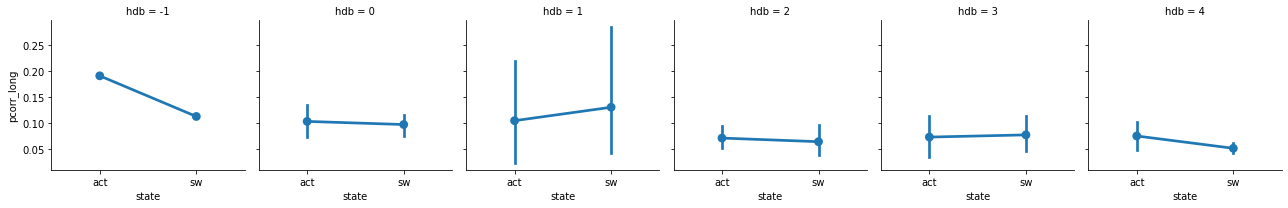

In [28]:
df_res["pcorr_long_abs"] = df_res["pcorr_long"].abs()

plt.figure()
sns.FacetGrid(data=df_res, col="hdb", sharey=True).map_dataframe(sns.pointplot, x="state", y="pcorr_long")

mod = smf.ols("pcorr_long ~ state * hdb", data=df_res).fit()
anova_lm(mod).round(2)

,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,0.00,0.00,1.87,0.18
hdb,1.0,0.01,0.01,7.48,0.01
state:hdb,1.0,0.00,0.00,0.01,0.91
Residual,78.0,0.08,0.00,NaN,NaN


<Figure size 432x288 with 0 Axes>

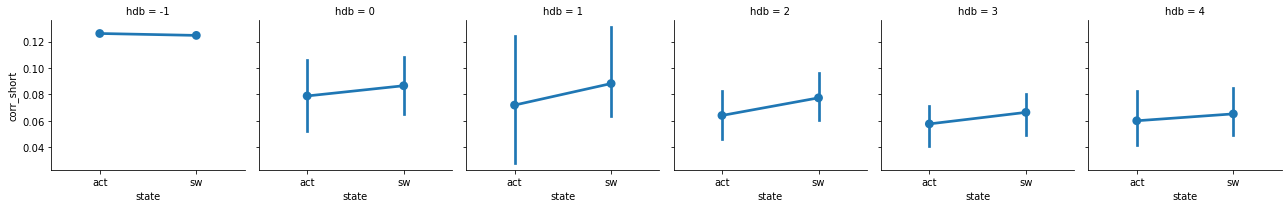

In [29]:


plt.figure()
sns.FacetGrid(data=df_res, 
col="hdb", sharey=True).map_dataframe(sns.pointplot, x="state", y="corr_short")

mod = smf.ols("corr_short ~ state * hdb", data=df_res).fit()
anova_lm(mod).round(2)

,df,sum_sq,mean_sq,F,PR(>F)
state,1.0,0.10,0.10,7.47,0.01
hdb,1.0,0.04,0.04,3.12,0.08
state:hdb,1.0,0.01,0.01,0.43,0.51
Residual,78.0,1.02,0.01,NaN,NaN


<Figure size 432x288 with 0 Axes>

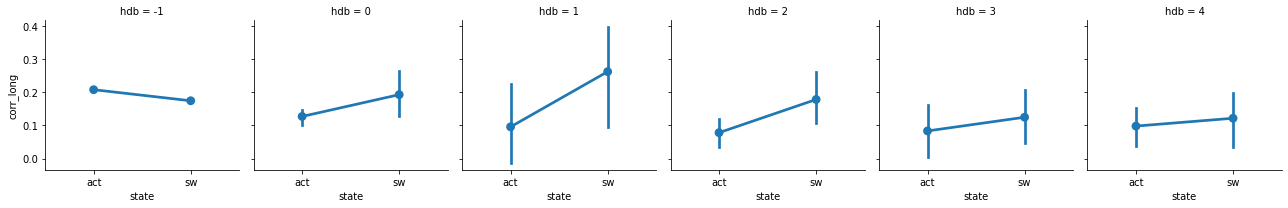

In [30]:
plt.figure()
sns.FacetGrid(data=df_res, 
col="hdb", sharey=True).map_dataframe(sns.pointplot, x="state", y="corr_long")

mod = smf.ols("corr_long ~ state * hdb", data=df_res).fit()
anova_lm(mod).round(2)

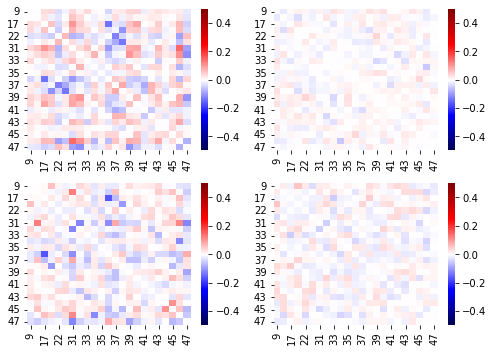

In [203]:
session_name = sessions[1]

sh = SpikesHandler(block="pre", t_start=0, t_stop=1800, bin_width=0.1, session_names=[session_name])

spikes = sh.binned_piv.reset_index()

eeg = eeg_states.loc[lambda x: x.session_name == session_name]


spikes2 = (
    spikes
    .copy()
    .assign(eeg_time = lambda x: which_bin(x.bin.values, eeg.timepoint_s.values, time_before=0, time_after=2))
    .merge(eeg, left_on="eeg_time", right_on="timepoint_s")
)

spikes2 = spikes2[list(spikes.columns) + ["cluster"]].set_index("bin")
sw_spikes = spikes2.loc[lambda x: x.cluster == "sw"].drop("cluster", axis=1).pipe(filter_active)
act_spikes = spikes2.loc[lambda x: x.cluster == "act"].drop("cluster", axis=1).pipe(filter_active)

# axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 5))[1].flatten()
# sns.heatmap(GraphicalLasso(alpha=0.005).fit(act_spikes.apply(zscore).dropna().values).precision_, center=0, robust=True, cmap="seismic", ax=axes[0], vmin=-0.5, vmax=0.5)
# sns.heatmap(GraphicalLasso(alpha=0.001).fit(act_spikes.apply(zscore).diff().dropna().values).precision_, center=0, robust=True, cmap="seismic", ax=axes[1], vmin=-0.2, vmax=0.2)
# sns.heatmap(GraphicalLasso(alpha=0.005).fit(sw_spikes.apply(zscore).dropna().values).precision_, center=0, robust=True, cmap="seismic", ax=axes[2], vmin=-0.5, vmax=0.5)
# sns.heatmap(GraphicalLasso(alpha=0.001).fit(sw_spikes.apply(zscore).diff().dropna().values).precision_, center=0, robust=True, cmap="seismic", ax=axes[3], vmin=-0.2, vmax=0.2)


axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 5))[1].flatten()

sns.heatmap(zero_diag(act_spikes.pcorr()), center=0, robust=True, cmap="seismic", ax=axes[0], vmin=-0.5, vmax=0.5)
sns.heatmap(zero_diag(act_spikes.diff().pcorr()), center=0, robust=True, cmap="seismic", ax=axes[1], vmin=-0.5, vmax=0.5)

sns.heatmap(zero_diag(sw_spikes.pcorr()), center=0, robust=True, cmap="seismic", ax=axes[2], vmin=-0.5, vmax=0.5)
sns.heatmap(zero_diag(sw_spikes.diff().pcorr()), center=0, robust=True, cmap="seismic", ax=axes[3], vmin=-0.5, vmax=0.5)
plt.tight_layout()

<AxesSubplot:title={'center':'value'}>

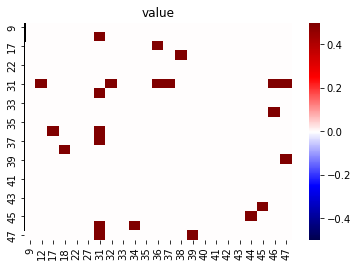

In [204]:
sw_spikes.pcorr().melt().loc[lambda x: x.value < 0.8].hist(color = "black", bins=50)

sns.heatmap(zero_diag(sw_spikes.pcorr()).abs() > 0.08, center=0, robust=True, cmap="seismic",  vmin=-0.5, vmax=0.5)

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

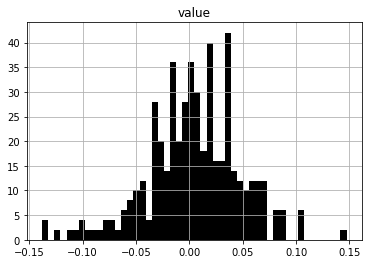

In [206]:
act_spikes.pcorr().melt().loc[lambda x: x.value < 0.8].hist(color = "black", bins=50)

# sns.heatmap(zero_diag(act_spikes.pcorr()).abs() > 0.08, center=0, robust=True, cmap="seismic",  vmin=-0.5, vmax=0.5)

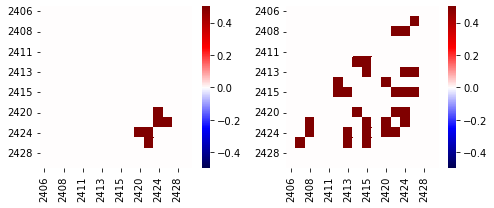

In [228]:
session_name = sessions[11]

sh = SpikesHandler(block="pre", t_start=0, t_stop=1800, bin_width=0.1, session_names=[session_name])

spikes = sh.binned_piv.reset_index()

eeg = eeg_states.loc[lambda x: x.session_name == session_name]


spikes2 = (
    spikes
    .copy()
    .assign(eeg_time = lambda x: which_bin(x.bin.values, eeg.timepoint_s.values, time_before=0, time_after=2))
    .merge(eeg, left_on="eeg_time", right_on="timepoint_s")
)

spikes2 = spikes2[list(spikes.columns) + ["cluster"]].set_index("bin")
sw_spikes = spikes2.loc[lambda x: x.cluster == "sw"].drop("cluster", axis=1).pipe(filter_active)
act_spikes = spikes2.loc[lambda x: x.cluster == "act"].drop("cluster", axis=1).pipe(filter_active)

# axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 5))[1].flatten()
# sns.heatmap(GraphicalLasso(alpha=0.005).fit(act_spikes.apply(zscore).dropna().values).precision_, center=0, robust=True, cmap="seismic", ax=axes[0], vmin=-0.5, vmax=0.5)
# sns.heatmap(GraphicalLasso(alpha=0.001).fit(act_spikes.apply(zscore).diff().dropna().values).precision_, center=0, robust=True, cmap="seismic", ax=axes[1], vmin=-0.2, vmax=0.2)
# sns.heatmap(GraphicalLasso(alpha=0.005).fit(sw_spikes.apply(zscore).dropna().values).precision_, center=0, robust=True, cmap="seismic", ax=axes[2], vmin=-0.5, vmax=0.5)
# sns.heatmap(GraphicalLasso(alpha=0.001).fit(sw_spikes.apply(zscore).diff().dropna().values).precision_, center=0, robust=True, cmap="seismic", ax=axes[3], vmin=-0.2, vmax=0.2)


axes = plt.subplots(ncols=2, figsize=(7, 3))[1].flatten()

sns.heatmap(zero_diag(act_spikes.corr()).abs() > 0.1, center=0, robust=True, cmap="seismic", ax=axes[0], vmin=-0.5, vmax=0.5)

sns.heatmap(zero_diag(sw_spikes.corr()).abs() > 0.1, center=0, robust=True, cmap="seismic", ax=axes[1], vmin=-0.5, vmax=0.5)
plt.tight_layout()